In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

Loading Data and Summary Statistics 

In [6]:
# df = pd.read_csv(r"/Users/NexusMacBookProYeo/Desktop/Y4S2/BT4211/data.csv", encoding="ISO-8859-1")
df = pd.read_csv(r"C:\Users\limng\Documents\Y4S2\BT4211\proj\BT4211_Group7\data.csv", encoding="ISO-8859-1")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
#summary for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [8]:
#summary for categegorical variables
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


Data Preparation - Cleaning and Transformation

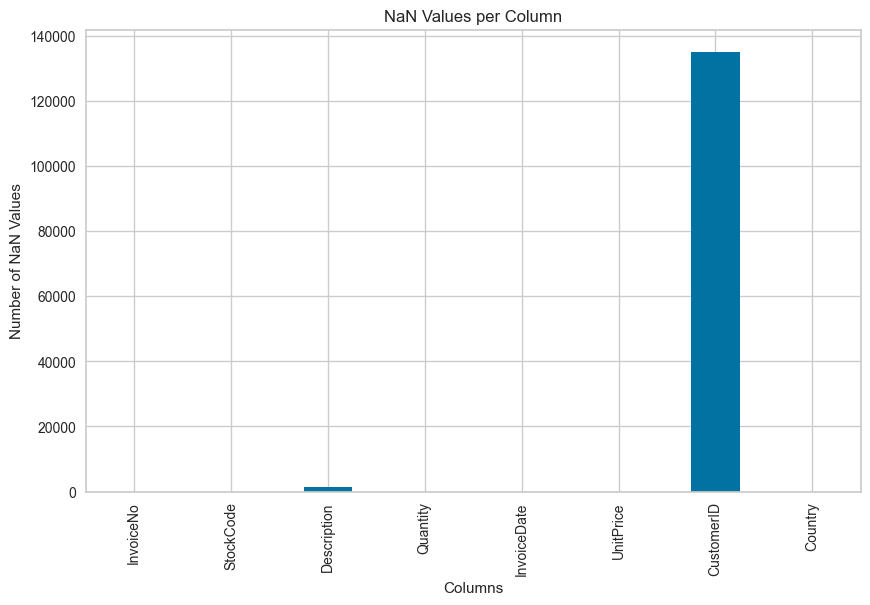

In [9]:
#Handling missing values
nan_counts = df.isna().sum()
nan_counts.plot(kind='bar', figsize=(10, 6), title='NaN Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.show()

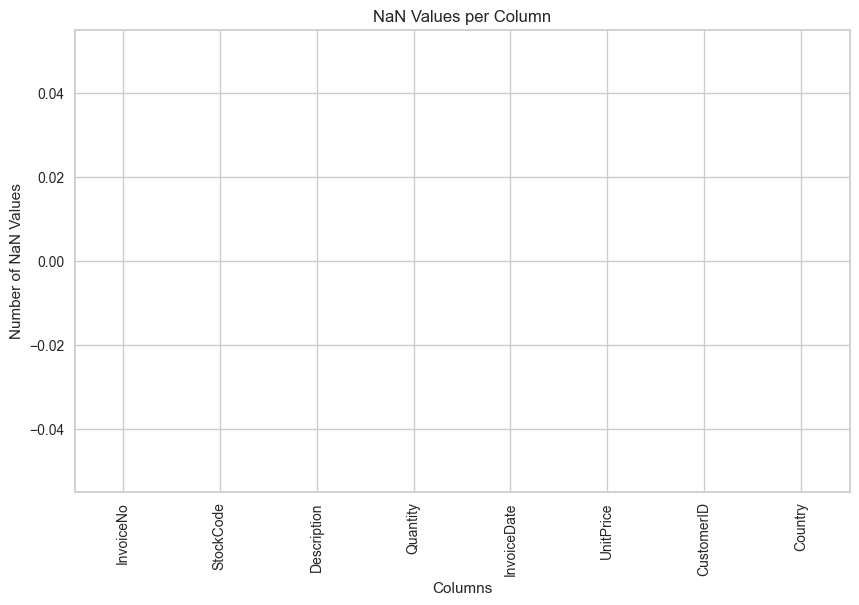

In [10]:
#drop missing values and verify that such rows have been dropped
df.dropna(inplace=True)
nan_counts = df.isna().sum()
nan_counts.plot(kind='bar', figsize=(10, 6), title='NaN Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.show()

In [11]:
#Handling duplicates
duplicated_rows = df[df.duplicated()]
duplicated_rows

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,12/1/2010 11:49,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom


In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      401604 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.6+ MB


EDA

In [100]:
# #Stockcode anomalies
# import matplotlib.pyplot as plt

# # Calculate the length of each Stockcode value
# # Calculate the length of each Stockcode value
# stockcode_lengths = df['StockCode'].str.len()

# # Count the occurrences of each unique length
# length_counts = stockcode_lengths.value_counts().reset_index()
# length_counts.columns = ['Length', 'Count']

# # Sort by length for better presentation
# length_counts = length_counts.sort_values(by='Length')

# # Display the table
# print(length_counts)


In [101]:
# df[df['StockCode']=="POST"]


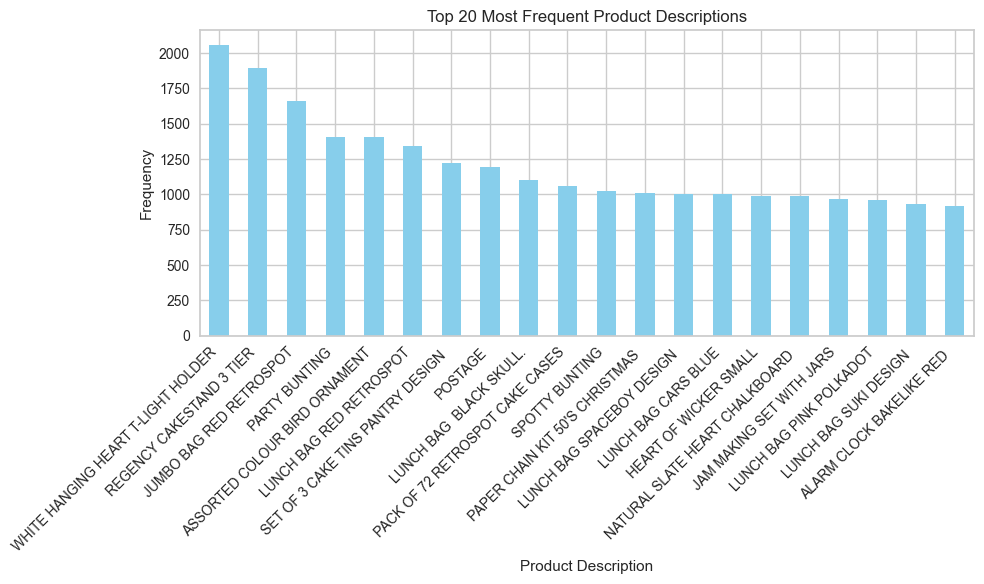

In [14]:
#EDA for Discription 
# Get the top 20 most frequent values in the product descriptions column
top_20_descriptions = df['Description'].value_counts().head(20)

# Plot the top 20 most frequent values
plt.figure(figsize=(10, 6))
top_20_descriptions.plot(kind='bar', color='skyblue')
plt.title('Top 20 Most Frequent Product Descriptions')
plt.xlabel('Product Description')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [15]:
#Investigating UnitPrice Discrepancies
df['UnitPrice'].describe()

count    401604.000000
mean          3.474064
std          69.764035
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: UnitPrice, dtype: float64

In [16]:
df.loc[df['UnitPrice'] > 1000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45622,C540271,M,Manual,-1,1/6/2011 11:51,1126.00,12503.0,Spain
73446,C542348,M,Manual,-1,1/27/2011 12:09,1715.85,12539.0,Spain
117052,C546325,M,Manual,-1,3/11/2011 10:15,1687.17,14911.0,EIRE
117053,C546327,M,Manual,-1,3/11/2011 10:18,1687.17,14911.0,EIRE
117054,546328,M,Manual,1,3/11/2011 10:19,1687.17,14911.0,EIRE
117055,546329,M,Manual,1,3/11/2011 10:22,1687.17,14911.0,EIRE
144826,548813,M,Manual,1,4/4/2011 13:03,2382.92,12744.0,Singapore
144828,548813,M,Manual,1,4/4/2011 13:03,1252.95,12744.0,Singapore
144829,548820,M,Manual,1,4/4/2011 13:04,2053.07,12744.0,Singapore
144831,C548830,M,Manual,-1,4/4/2011 13:08,2382.92,12744.0,Singapore


In [105]:
##MIGHT USE TO EVENTUALLY DROP ROWS WITH USELESS DESCRIPTIONS
# lowercase_descriptions = df['Description'].unique()
# lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# # Print the unique descriptions containing lowercase characters
# print("The unique descriptions containing lowercase characters are:")
# print("-"*60)
# for desc in lowercase_descriptions:
#     print(desc)

In [17]:
#Investigating anomalies in StockCode, as shown above, stockcodes usually contain numeric values, however, all the rows with extreme values contain only alphabets in stockcode
no_numeric_mask = ~df['StockCode'].str.contains(r'\d')

# Use the boolean mask to filter the DataFrame
rows_with_no_numeric = df[no_numeric_mask]

rows_with_no_numeric['StockCode'].unique()


array(['POST', 'D', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [18]:
df = df[df['StockCode'].str.contains(r'\d')]

In [19]:
df['UnitPrice'].describe()

count    399823.000000
mean          2.923285
std           4.537682
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [20]:
#check if there are any exisiting columns with unitprice 0
df[df['UnitPrice']==0]
df = df[df['UnitPrice'] != 0]


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399790 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    399790 non-null  object 
 1   StockCode    399790 non-null  object 
 2   Description  399790 non-null  object 
 3   Quantity     399790 non-null  int64  
 4   InvoiceDate  399790 non-null  object 
 5   UnitPrice    399790 non-null  float64
 6   CustomerID   399790 non-null  float64
 7   Country      399790 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.5+ MB


FEATURE ENGINEERING -RFM

RECENCY

In [22]:
# Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

customer_data

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310
...,...,...
4357,18280.0,277
4358,18281.0,180
4359,18282.0,7
4360,18283.0,3


FREQUENCY 

In [23]:
#total transactions made by each customer
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01


In [24]:
num_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
num_transactions.rename(columns = {"InvoiceNo": "Num_Transactions"}, inplace = True)
# num_transactions
customer_data = pd.merge(customer_data, num_transactions, on="CustomerID")
customer_data


,CustomerID,Days_Since_Last_Purchase,Num_Transactions
0,12346.0,325,2
1,12347.0,2,7
2,12348.0,75,4
3,12349.0,18,1
4,12350.0,310,1
...,...,...,...
4357,18280.0,277,1
4358,18281.0,180,1
4359,18282.0,7,3
4360,18283.0,3,16


MONETARY

In [25]:
#total spending for each customer
df.loc[df['Quantity'] < 0, 'Sales'] = 0
df['Sales'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Sales'].sum().reset_index()
total_spend.rename(columns={"Sales":"Total_Spending"}, inplace=True)

customer_data = pd.merge(customer_data, total_spend, on='CustomerID')



In [26]:
#total quantity of products purchased per customer
total_quantity = df.groupby('CustomerID')['Quantity'].sum()
customer_data = pd.merge(customer_data, total_quantity, on='CustomerID')
customer_data.rename(columns = {"Quantity":"Total_Quantity"}, inplace=True)
customer_data


,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity
0,12346.0,325,2,0.00,0
1,12347.0,2,7,4310.00,2458
2,12348.0,75,4,1437.24,2332
3,12349.0,18,1,1457.55,630
4,12350.0,310,1,294.40,196
...,...,...,...,...,...
4357,18280.0,277,1,180.60,45
4358,18281.0,180,1,80.82,54
4359,18282.0,7,3,176.60,98
4360,18283.0,3,16,2039.58,1355


In [27]:
#average spending per product purchased
customer_data['Average_Spending'] = customer_data['Total_Spending'] / customer_data['Num_Transactions']
# customer_data['Average_Spending'] = customer_data['Average_Spending'].fillna(0)
customer_data

,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending
0,12346.0,325,2,0.00,0,0.000000
1,12347.0,2,7,4310.00,2458,615.714286
2,12348.0,75,4,1437.24,2332,359.310000
3,12349.0,18,1,1457.55,630,1457.550000
4,12350.0,310,1,294.40,196,294.400000
...,...,...,...,...,...,...
4357,18280.0,277,1,180.60,45,180.600000
4358,18281.0,180,1,80.82,54,80.820000
4359,18282.0,7,3,176.60,98,58.866667
4360,18283.0,3,16,2039.58,1355,127.473750


MORE EXTENSIVE FEATURE ENGINEERING

In [28]:
#total number of different products purchased by customer
products = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
customer_data = pd.merge(customer_data, products, on="CustomerID")
customer_data.rename(columns = {"StockCode":"Unique_Products"}, inplace= True)
customer_data

,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending,Unique_Products
0,12346.0,325,2,0.00,0,0.000000,1
1,12347.0,2,7,4310.00,2458,615.714286,103
2,12348.0,75,4,1437.24,2332,359.310000,21
3,12349.0,18,1,1457.55,630,1457.550000,72
4,12350.0,310,1,294.40,196,294.400000,16
...,...,...,...,...,...,...,...
4357,18280.0,277,1,180.60,45,180.600000,10
4358,18281.0,180,1,80.82,54,80.820000,7
4359,18282.0,7,3,176.60,98,58.866667,12
4360,18283.0,3,16,2039.58,1355,127.473750,262


In [34]:
#max purchase to find high spenders and low spenders
df1 = df.copy()
df1['TotalPrice'] = df1['Quantity'] * df1['UnitPrice']
max_purchase_value = df1.groupby('CustomerID')['TotalPrice'].max().rename('MaxPurchaseValue')
max_purchase_value

CustomerID
12346.0    77183.60
12347.0      249.60
12348.0      150.00
12349.0       63.80
12350.0       25.20
             ...   
18280.0       23.70
18281.0       16.95
18282.0       25.50
18283.0       20.80
18287.0       87.00
Name: MaxPurchaseValue, Length: 4362, dtype: float64

In [43]:

# max_purchase_value = max_purchase_value.to_frame().reset_index()
max_purchase_value
customer_data = pd.merge(customer_data, max_purchase_value, on="CustomerID")
customer_data


,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending,Unique_Products,MaxPurchaseValue
0,12346.0,325,2,0.00,0,0.000000,1,77183.60
1,12347.0,2,7,4310.00,2458,615.714286,103,249.60
2,12348.0,75,4,1437.24,2332,359.310000,21,150.00
3,12349.0,18,1,1457.55,630,1457.550000,72,63.80
4,12350.0,310,1,294.40,196,294.400000,16,25.20
...,...,...,...,...,...,...,...,...
4357,18280.0,277,1,180.60,45,180.600000,10,23.70
4358,18281.0,180,1,80.82,54,80.820000,7,16.95
4359,18282.0,7,3,176.60,98,58.866667,12,25.50
4360,18283.0,3,16,2039.58,1355,127.473750,262,20.80


In [44]:
#customer loyalty fromt their first purcahse

latest_date = df1['InvoiceDate'].max() + pd.Timedelta(days=1)  # plus one day so recency=0 wont happen
first_purchase = df1.groupby('CustomerID')['InvoiceDate'].min()
customer_loyalty = (latest_date - first_purchase).dt.days.rename('CustomerLoyalty')
customer_loyalty= customer_loyalty.to_frame().reset_index()
customer_data = pd.merge(customer_data, customer_loyalty, on="CustomerID")

In [45]:
customer_data

,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending,Unique_Products,MaxPurchaseValue,CustomerLoyalty
0,12346.0,325,2,0.00,0,0.000000,1,77183.60,326
1,12347.0,2,7,4310.00,2458,615.714286,103,249.60,367
2,12348.0,75,4,1437.24,2332,359.310000,21,150.00,358
3,12349.0,18,1,1457.55,630,1457.550000,72,63.80,19
4,12350.0,310,1,294.40,196,294.400000,16,25.20,310
...,...,...,...,...,...,...,...,...,...
4357,18280.0,277,1,180.60,45,180.600000,10,23.70,278
4358,18281.0,180,1,80.82,54,80.820000,7,16.95,181
4359,18282.0,7,3,176.60,98,58.866667,12,25.50,126
4360,18283.0,3,16,2039.58,1355,127.473750,262,20.80,337


In [30]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-09,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-09,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09,16.60


In [46]:
# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

C:\Users\limng\AppData\Local\Temp\ipykernel_33264\2472798512.py:6: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))


In [47]:
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')

In [48]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending,Unique_Products,MaxPurchaseValue,CustomerLoyalty,Average_Days_Between_Purchases,Day_Of_Week
0,12346.0,325,2,0.00,0,0.000000,1,77183.6,326,0.000000,1
1,12347.0,2,7,4310.00,2458,615.714286,103,249.6,367,2.016575,1
2,12348.0,75,4,1437.24,2332,359.310000,21,150.0,358,10.884615,3
3,12349.0,18,1,1457.55,630,1457.550000,72,63.8,19,0.000000,0
4,12350.0,310,1,294.40,196,294.400000,16,25.2,310,0.000000,2


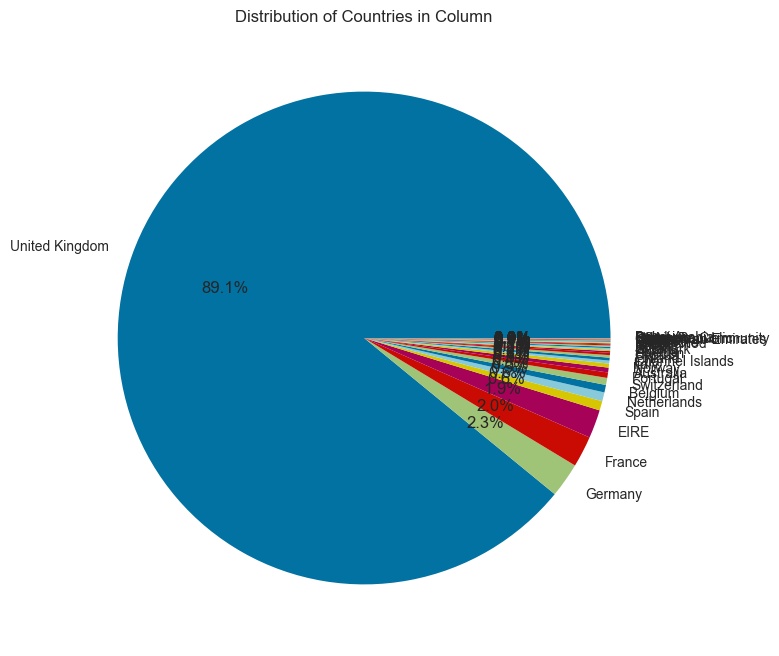

In [49]:
#location
value_counts = df['Country'].value_counts()
value_counts
plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Countries in Column')
plt.show()

In [50]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending,Unique_Products,MaxPurchaseValue,CustomerLoyalty,Average_Days_Between_Purchases,Day_Of_Week,Is_UK
0,12346.0,325,2,0.00,0,0.000000,1,77183.6,326,0.000000,1,1
1,12347.0,2,7,4310.00,2458,615.714286,103,249.6,367,2.016575,1,0
2,12348.0,75,4,1437.24,2332,359.310000,21,150.0,358,10.884615,3,0
3,12349.0,18,1,1457.55,630,1457.550000,72,63.8,19,0.000000,0,0
4,12350.0,310,1,294.40,196,294.400000,16,25.2,310,0.000000,2,0


CANCELLATION 

In [51]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,Sales,Day_Of_Week,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30,2,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34,2,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00,2,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34,2,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34,2,8


In [52]:
# Filter out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# Analyze the characteristics of these rows (considering the new column)
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,InvoiceDate,UnitPrice,Sales,Day_Of_Week,Hour
count,8507.000000,8507,8507.000000,8507.000000,8507.000000,8507.000000
mean,-31.469613,2011-06-27 00:27:39.398142976,4.445504,-55.460293,2.246738,13.164570
min,-80995.000000,2010-12-01 09:49:00,0.030000,-168469.600000,0.000000,6.000000
25%,-6.000000,2011-03-21 16:26:00,1.450000,-16.600000,1.000000,11.000000
50%,-2.000000,2011-07-11 13:07:00,2.550000,-8.300000,2.000000,13.000000
75%,-1.000000,2011-10-06 20:38:00,4.950000,-3.300000,3.000000,15.000000
max,-1.000000,2011-12-09 11:58:00,295.000000,-0.120000,6.000000,20.000000
std,1196.981277,NaN,9.211853,2014.017603,1.567852,2.725717


In [53]:
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

# Printing the percentage of cancelled transactions
print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")

The percentage of cancelled transactions in the dataset is: 2.13%


In [54]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending,Unique_Products,MaxPurchaseValue,CustomerLoyalty,Average_Days_Between_Purchases,Day_Of_Week,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0.00,0,0.000000,1,77183.6,326,0.000000,1,1,1.0,0.5
1,12347.0,2,7,4310.00,2458,615.714286,103,249.6,367,2.016575,1,0,0.0,0.0
2,12348.0,75,4,1437.24,2332,359.310000,21,150.0,358,10.884615,3,0,0.0,0.0
3,12349.0,18,1,1457.55,630,1457.550000,72,63.8,19,0.000000,0,0,0.0,0.0
4,12350.0,310,1,294.40,196,294.400000,16,25.2,310,0.000000,2,0,0.0,0.0


OUTLIER DETECTION

In [55]:
#isolation forest algorithm
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# # Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# # Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending,Unique_Products,MaxPurchaseValue,CustomerLoyalty,Average_Days_Between_Purchases,Day_Of_Week,Is_UK,Cancellation_Frequency,Cancellation_Rate,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0.00,0,0.000000,1,77183.6,326,0.000000,1,1,1.0,0.5,-1,1
1,12347.0,2,7,4310.00,2458,615.714286,103,249.6,367,2.016575,1,0,0.0,0.0,1,0
2,12348.0,75,4,1437.24,2332,359.310000,21,150.0,358,10.884615,3,0,0.0,0.0,1,0
3,12349.0,18,1,1457.55,630,1457.550000,72,63.8,19,0.000000,0,0,0.0,0.0,-1,1
4,12350.0,310,1,294.40,196,294.400000,16,25.2,310,0.000000,2,0,0.0,0.0,1,0


In [56]:
#percentage of outliers
customer_data
distribution_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100
distribution_percentage

Is_Outlier
0    94.983668
1     5.016332
Name: proportion, dtype: float64

In [57]:
#remove outliers
customer_data = customer_data.loc[customer_data['Is_Outlier'] == 0]

CORRELATION ANALYSIS

c:\Users\limng\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


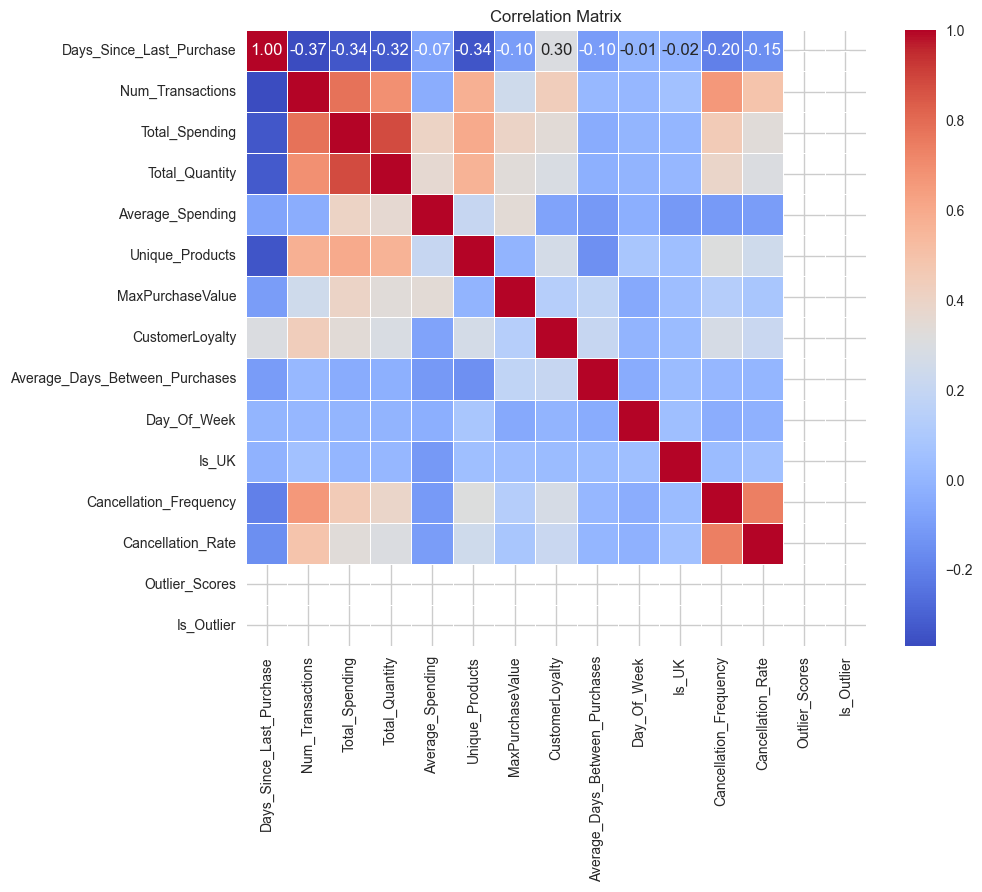

In [58]:
# Assuming customer_data is your DataFrame
# Drop the 'CustomerID' column
customer_data_without_id = customer_data.drop(columns=['CustomerID'])

# Compute the correlation matrix
correlation_matrix = customer_data_without_id.corr()

# Display the correlation matrix
# print(correlation_matrix)
correlation_matrix = customer_data_without_id.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

NORMALIZATION - SCALING

In [59]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending,Unique_Products,MaxPurchaseValue,CustomerLoyalty,Average_Days_Between_Purchases,Day_Of_Week,Is_UK,Cancellation_Frequency,Cancellation_Rate,Outlier_Scores,Is_Outlier
1,12347.0,-0.908417,0.745992,2.318692,1.987121,1.475064,0.807298,1.589747,1.239317,-0.136439,1,0,-0.544548,-0.443894,0.0,0.0
2,12348.0,-0.173867,0.006659,0.234033,1.846646,0.317681,-0.571667,0.641462,1.162959,0.867656,3,0,-0.544548,-0.443894,0.0,0.0
4,12350.0,2.190779,-0.732674,-0.595284,-0.534732,0.024684,-0.655750,-0.546751,0.755721,-0.364768,2,0,-0.544548,-0.443894,0.0,0.0
5,12352.0,-0.566298,0.992437,0.109343,-0.237060,-0.590217,0.033732,-0.422503,0.645427,-0.010084,1,0,0.422245,-0.227448,0.0,0.0
6,12353.0,1.124173,-0.732674,-0.744336,-0.730950,-0.902471,-0.857549,-0.407746,-0.143597,-0.364768,3,0,-0.544548,-0.443894,0.0,0.0


In [60]:
customer_data.describe()

,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending,Unique_Products,MaxPurchaseValue,CustomerLoyalty,Average_Days_Between_Purchases,Day_Of_Week,Is_UK,Cancellation_Frequency,Cancellation_Rate,Outlier_Scores,Is_Outlier
count,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.0,4071.0
mean,15329.788013,92.279047,3.972980,1114.730631,675.633014,288.931645,54.994105,82.626205,220.925325,3.221588,2.559076,0.914763,0.563252,0.256354,1.0,0.0
std,1703.725747,99.392806,4.058208,1378.217665,897.069789,221.565228,59.472224,105.044571,117.881591,8.832958,1.856759,0.279268,1.034475,0.577582,0.0,0.0
min,12347.000000,0.000000,1.000000,-1192.200000,-303.000000,-1192.200000,1.000000,-122.400000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
25%,13872.000000,18.000000,1.000000,291.710000,152.000000,151.514000,16.000000,30.600000,107.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.0,0.0
50%,15341.000000,51.000000,2.000000,616.650000,347.000000,232.840000,34.000000,49.800000,247.000000,1.213333,2.000000,1.000000,0.000000,0.000000,1.0,0.0
75%,16791.500000,143.000000,5.000000,1400.130000,843.000000,358.277500,73.000000,90.000000,324.000000,3.180797,4.000000,1.000000,1.000000,0.250000,1.0,0.0
max,18287.000000,373.000000,39.000000,14520.080000,11470.000000,2062.060000,500.000000,1790.000000,374.000000,285.000000,6.000000,1.000000,8.000000,5.000000,1.0,0.0


PRINCIPAL COMPONENT ANALYSIS (PCA)

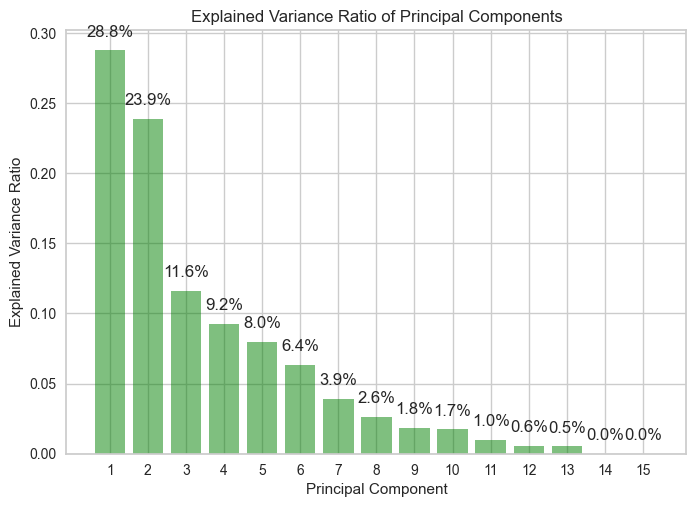

In [61]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('CustomerID', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)
# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Create a bar plot with green bars
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', color='green')

# Set custom x-axis ticks and labels for each principal component
plt.xticks(range(1, len(explained_variance_ratio) + 1))

# Add percentage values above each bar
for i, ev in enumerate(explained_variance_ratio):
    plt.text(i + 1, ev + 0.01, f'{ev*100:.1f}%', ha='center')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.show()


CLUSTERING